Text Classification with Deep Learning

Author: Ignacio Ramos Garcia


In this project news classification between true or fake will be carried out. Datasets are available in the following link:

https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset#True.csv

## Imports

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import drive

import csv
import numpy as np
import pandas as pd
import seaborn as sns


from pandas import read_csv
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, LSTM, Embedding, Dropout, Bidirectional,\
SpatialDropout1D, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras import layers, initializers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

from matplotlib import pyplot as plt

%matplotlib inline



## Load data and preprocessing

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path_data = "/content/gdrive/MyDrive/Master Big Data Science UNAV/8.Deep_learning/Tasks/Tasks/Data/"

In [ ]:
df_fake = read_csv(path_data + 'Fake.csv')
df_true = read_csv(path_data + 'True.csv')

In [ ]:
# setting label as 0 for fake
df_fake['target']=0

# setting label 1 for true
df_true['target']=1
df_true.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
# merging both fake and true datasets
df = pd.concat([df_fake,df_true])

In [ ]:
# Mix fake and true rows
df = df.sample(frac=1)

df.head()

,title,text,subject,date,target
2983,President Trump to attend Paris July 14 celebr...,PARIS (Reuters) - President Donald Trump will ...,politicsNews,"June 28, 2017",1
15343,HILLARY CLINTON CRASHING IN POLLS: Moves To Ob...,"So, the working people of America are basicall...",politics,"Aug 10, 2015",0
7964,North Carolina Drug Tested Welfare Recipients...,Republicans must be shocked. And taxpayers sho...,News,"February 20, 2016",0
4457,New Poll Shows 40 Percent Of Trump Supporters...,When Hillary Clinton called out half of Trum...,News,"September 28, 2016",0
23434,"The Final Control: TPP, TTIP, TISA Global Corp...",21st Century Wire says This is a new geopoliti...,Middle-east,"February 27, 2016",0


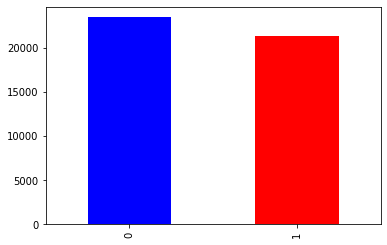

In [ ]:
# Plot distribution of both targets
df['target'].value_counts().plot.bar(color=['blue','red'])

In [ ]:
df['original'] = df['text'] + ' ' + df['title']

### Cleaning Text

In [ ]:
pat1 = r'http[^ ]+' # pattern to remove links
pat2 = r'www.[^ ]+' # pattern to remove links
pat3 = '[^a-zA-Z]+' # pattern to remove numbers
pat = r'|'.join((pat1, pat2, pat3))

def get_clean_text(text):
    text = text.lower() # lowercase
    text = re.sub(pat, ' ', text) # remove pat
    text = [w for w in tok.tokenize(text) if not w in stop_words] # remove stop_words
    text = [w for w in text if len(w)>1] # remove words with len <2
    text = (' '.join(text)).strip() # list to string
    return text

In [ ]:
df['text_clean'] = [get_clean_text(t) for t in df['original']]

### Lemmatization 


In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatization(text):
    lemmas = []
    for word in text.split():
        lemmas.append(lemmatizer.lemmatize(word))
    return " ".join(lemmas)

In [ ]:
df['text_clean'] = df['text_clean'].apply(lemmatization)

## Model

### Hyperparameters

In [ ]:
epochs = 10
batch_size = 256
vocab_size = 15000 # max tokens to be considered in vocabulary based on frequency
embedding_dim = 50 # embedding dimension. This is the word vector representation size
max_length = 300 # tokens expected per each text
# num_convolution = 5
trunc_type = 'post' # in case of exceeding "max_length", then truncate the sequence.
padding_type = 'post' # in case of not fulfilling "max_length", then add zeroes in the the sequence.
oov_tok = '<OOV>' # code for unseen tokens
training_portion = .6
training_portion = .8

### Train-test split

In [ ]:
y = df['target']
x = df['text_clean']

label_distinct = len(set(y)) # this might be use as a dynamic parameter for the cost function layer (number of output neurons)
print('Distinct categories in train set :' + str(label_distinct))

x_train,x_test,y_train,y_test = train_test_split(df.text_clean,
                                                 df.target,random_state = 0)

print('x_train records :' + str(len(x_train)))
print('y_train records :' + str(len(y_train)))
print('x_test records :' + str(len(x_test)))
print('y_test records :' + str(len(y_test)))

Distinct categories in train set :2
x_train records :33673
y_train records :33673
x_test records :11225
y_test records :11225


### Tokenize

In [ ]:
# As opposose to labels, Tokenizer for text has to be parametrized
tokenizer = Tokenizer(num_words = vocab_size # max words to be considered
                      , oov_token=oov_tok) #I want "OOV" in bracket to be used to for words that are not in the word index.
tokenizer.fit_on_texts(x_train) # fit will return a dictionary
word_index = tokenizer.word_index # save indexes for reverse transformation
print('____________________________________________________________')
print('This is an example for 5 tokens in the word_index :' + str(dict(list(word_index.items())[0:5])))

____________________________________________________________
This is an example for 5 tokens in the word_index :{'<OOV>': 1, 'trump': 2, 'said': 3, 'state': 4, 'president': 5}


In [ ]:
x_train_seq = tokenizer.texts_to_sequences(x_train)

In [ ]:
x_test_seq = tokenizer.texts_to_sequences(x_test)

### Padding

In [ ]:
x_train_pad = pad_sequences(x_train_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_length,padding=padding_type, truncating=trunc_type)

### Glove


In [ ]:
pre_trained_embedding = path_data +  "glove.6B.50d.txt"

In [ ]:

def get_coefs(word, *arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(pre_trained_embedding))

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]



nb_words = min(vocab_size, len(word_index))
#change below line if computing normal stats is too slow
ebedding_matrix = embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))
for word, i in word_index.items():
    if i >= vocab_size: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if self.run_code(code, result):


### Model

#### Callbacks

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.5, min_lr=0.00001)

earlystop = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

callbacks_list = [earlystop,reduce_lr] 


#### Model implementation

In [ ]:
#Defining Neural Network
def make_model(  bidirectional_layers = 1
               , bidirectional_dropout = 0.0
               , dense_layers = 1
               , dense_dropout = 0.0
               , lr = 0.01
               , output_bias = None
                , verbose = 1):

    model = Sequential()

    model.add(Embedding(vocab_size, 
                        output_dim=embed_size, 
                        weights=[embedding_matrix], 
                        input_length=max_length, 
                        trainable=False))

    model.add(LSTM(units=128 
                  , return_sequences = True 
                  , recurrent_dropout = 0.25 
                  , dropout = 0.25))
    model.add(LSTM(units=64 
                  , recurrent_dropout = 0.1 
                  , dropout = 0.1))

    model.add(Dense(units = 32 , activation = 'relu'))

    # bias the cost function
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros' 
    model.add(Dense(1
                    , activation='sigmoid'
                    , bias_initializer = output_bias))
    model.compile(loss = 'binary_crossentropy' # return prob dist
                  , optimizer = Adam(lr) # classic classification optimizer
                  , metrics = ['accuracy'])
    model.compile(optimizer=Adam(lr=0.01)
                  , loss='binary_crossentropy'
                  , metrics=['accuracy'])

    model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 50)           750000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 300, 128)          91648     
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_12 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 893,169
Trainable params: 143,169
Non-trainable params: 750,000
_________________________________________________________________


In [ ]:
len_word_index = len(word_index)
def make_model(  bidirectional_layers = 1
               , bidirectional_dropout = 0.0
               , dense_layers = 1
               , dense_dropout = 0.0
               , lr = 1e-3
               , output_bias = None
               , verbose = 1):
    
    model = Sequential()
    
    model.add(Embedding(input_dim = len_word_index + 1 # the entering token j (j its a number) 
        #finds it´s word representation in the j row, where rows are "len_word_index + 1".
                       , output_dim = embedding_dim # word representation dimension. Question
                       , weights = [embedding_matrix] # pretrained embedding
                       , input_length = max_length # Expected text size
                       , trainable = False)) # Trainable = True when embedding elegigble to change
    
    for i in range(0,bidirectional_layers):
        
        # return_sequences -> last bidirectional doesnt return requences
        return_sequences = ((bidirectional_layers - i) != 1)
        model.add(Bidirectional(LSTM(embedding_dim
                                 , activation = 'relu'
                                 , dropout = bidirectional_dropout # regularization 
                                 , recurrent_dropout = bidirectional_dropout # regularization
                                 , return_sequences = return_sequences))
                  )

    for i in range(0,dense_layers):
        model.add(Dense(embedding_dim, activation='relu')) # dense layers
        if dense_dropout != 0.0:
            model.add(Dropout(dense_dropout)) # regularization
            
    # bias the cost function
    if output_bias is not None:
        output_bias = initializers.Constant(output_bias)
    else:
        output_bias = 'zeros'    
    
    model.add(Dense(1 
                    , activation='softmax'
                    , bias_initializer = output_bias))    

    model.compile(loss = 'binary_crossentropy' # return prob dist
                  , optimizer = Adam(lr) # classic classification optimizer
                  , metrics = ['accuracy'])
    if verbose:
        
        print('bidirectional_layers :' + str(bidirectional_layers))
        print('bidirectional_dropout :' + str(bidirectional_dropout))
        print('dense_layers :' + str(dense_layers))
        print('dense_dropout :' + str(dense_dropout))
        print('lr :' + str(lr))

        print(model.summary())
    
    return model

In [ ]:
model_2 = make_model(bidirectional_layers = 2
               , bidirectional_dropout = 0.2
               , dense_layers = 1
               , dense_dropout = 0.0
               , lr = 0.01
               , output_bias = None
               , verbose = 1)



bidirectional_layers :2
bidirectional_dropout :0.2
dense_layers :1
dense_dropout :0.0
lr :0.01
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 50)           5004250   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 300, 100)          40400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 5,110,151
Trainable params: 105,901
Non-trainable params: 5,004,250
_________________________________________________________________
None


#### Model training

In [ ]:
history = model.fit(x_train_pad, y_train
                    , epochs=epochs
                    , batch_size = batch_size
                    , validation_data=(x_test_pad, y_test)
                    , callbacks = callbacks_list
                    , verbose=1)

Epoch 1/10
132/132 [==============================] - 615s 5s/step - loss: 0.0077 - accuracy: 0.9980 - val_loss: 0.0082 - val_accuracy: 0.9987
Epoch 2/10
132/132 [==============================] - 652s 5s/step - loss: 0.0071 - accuracy: 0.9983 - val_loss: 0.0109 - val_accuracy: 0.9978
Epoch 3/10
132/132 [==============================] - 629s 5s/step - loss: 0.0061 - accuracy: 0.9988 - val_loss: 0.0074 - val_accuracy: 0.9987

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
Epoch 4/10
132/132 [==============================] - 614s 5s/step - loss: 0.0039 - accuracy: 0.9990 - val_loss: 0.0069 - val_accuracy: 0.9988
Epoch 5/10
132/132 [==============================] - 622s 5s/step - loss: 0.0306 - accuracy: 0.9929 - val_loss: 0.0154 - val_accuracy: 0.9968
Epoch 6/10
132/132 [==============================] - 597s 5s/step - loss: 0.0109 - accuracy: 0.9977 - val_loss: 0.0100 - val_accuracy: 0.9980

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00

In [ ]:
model.save(path_data + 'model_text_classification.h5')

#### Prediction with test data

In [ ]:
pred = model.predict_classes(x_test_pad)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


## Results

### Accuracy and Loss

In [ ]:
history_dict = history.history

acc = history_dict['accuracy']
test_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

print('Train accuracy : ' + str(acc[-1]))
print('Test accuracy : ' + str(test_acc[-1]))

Train accuracy : 0.998723030090332
Test accuracy : 0.9982182383537292


In [ ]:
pred = model.predict_classes(x_test_pad)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


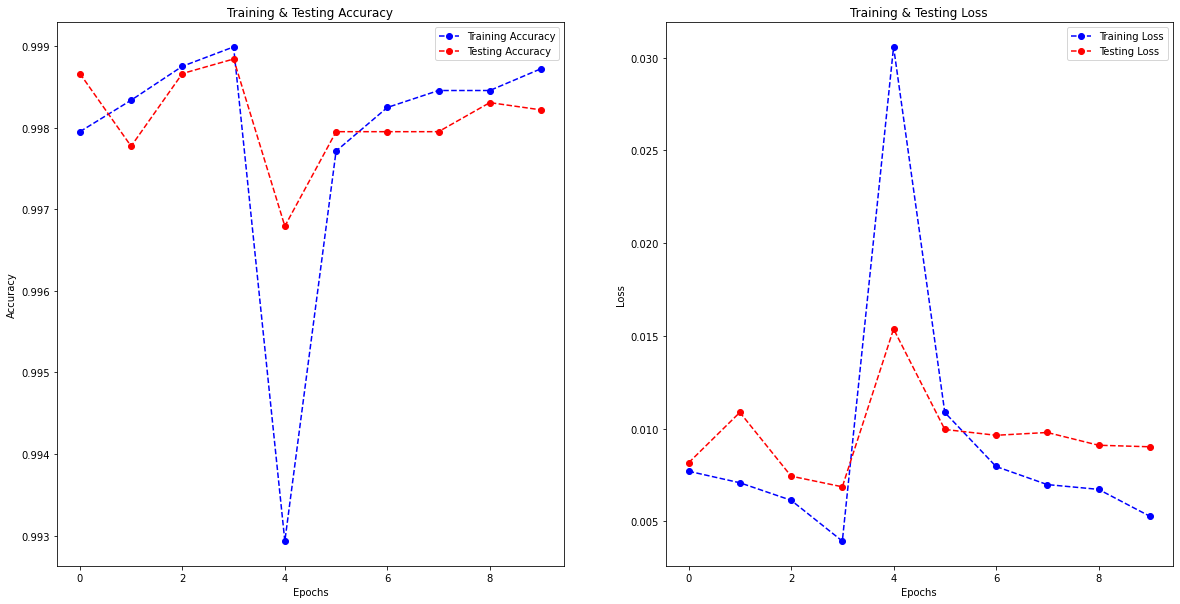

In [ ]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'bo--' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro--' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'bo--' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro--' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

### Confusion matrix

Text(69.0, 0.5, 'Actual')

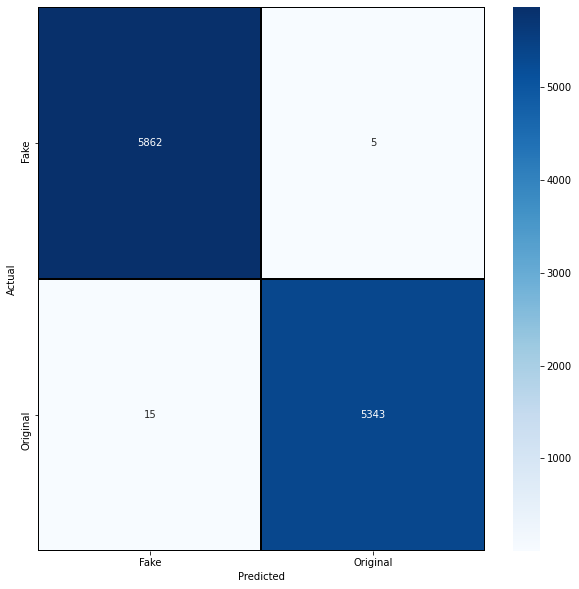

In [ ]:
conf_matrix = confusion_matrix(y_test,pred)
plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")